In [1]:
%pip install -r C:\Users\AubreeWang\deep-speaker\requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import sys
import random
import re
import glob
from tqdm import tqdm
import importlib
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import umap

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)
from deep_speaker.test import batch_cosine_similarity
# print(sys.path)
# from sak import speaker_embeddings as se
# from sak import signal_processing as sp
# from sak import vctk


In [3]:
# the directory wherey you downloaded VCTK. 
vctk_dir = r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92"
# the directory where you work i.e. save speaker embeddings.
work_dir = r"C:\Users\AubreeWang\deep-speaker\deep_speaker"

# you should download the deep speaker model
# and describe the path here.
checkpoint_path = r'C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5'

## VCTK embedding space.

In [4]:
def load_vctk_metadata():
    with open(os.path.join(vctk_dir, 'speaker-info.txt')) as f:
        lines = f.read().strip().split('\n')
    
    # remove the header.
    # ID  AGE  GENDER  ACCENTS  REGION COMMENTS
    header = ['id', 'age', 'gender', 'accent', 'region']
    lines = lines[1:]

    ## make a database of metadata.
    meta = pd.DataFrame([], columns=header)
    for i, line in enumerate(lines):
        result = re.findall(r'(\w+)\s+(\d+)\s+(M|F)\s+(\w+)\s*([\w\s]*)', line)
        result = {result[0]}
        meta = pd.concat([meta, pd.DataFrame(result, columns=header)], ignore_index=True)

    return meta

In [5]:
vctk_wavs_dir = os.path.join(vctk_dir, 'wav16')
vctk_embeddings_dir = os.path.join(work_dir, 'embeddings', 'vctk')

# check vctk meta data. 
meta = load_vctk_metadata()
meta

,id,age,gender,accent,region
0,p225,23,F,English,Southern England
1,p226,22,M,English,Surrey
2,p227,38,M,English,Cumbria
3,p228,22,F,English,Southern England
4,p229,23,F,English,Southern England
...,...,...,...,...,...
105,p363,22,M,Canadian,Toronto
106,p364,23,M,Irish,Donegal
107,p374,28,M,Australian,English
108,p376,22,M,Indian,


In [6]:
## analyse the data
meta_ = meta[meta['accent'] == 'English']
c = Counter(meta_['gender'])
c.most_common()

[('F', 18), ('M', 15)]

In [7]:
meta_

,id,age,gender,accent,region
0,p225,23,F,English,Southern England
1,p226,22,M,English,Surrey
2,p227,38,M,English,Cumbria
3,p228,22,F,English,Southern England
4,p229,23,F,English,Southern England
5,p230,22,F,English,Stockton
6,p231,23,F,English,Southern England
7,p232,23,M,English,Southern England
8,p233,23,F,English,Staffordshire
10,p236,23,F,English,Manchester


## extract speaker embeddings.

In [8]:
## test the sample code given by the author.
import random
import os
import sys
import numpy as np

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Define the model here.
model = DeepSpeakerModel()

# Load the checkpoint. https://drive.google.com/file/d/1F9NvdrarWZNktdX9KlRYWWHDwRkip_aP.
# Also available here: https://share.weiyun.com/V2suEUVh (Chinese users).
model.m.load_weights(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

# Sample some inputs for WAV/FLAC files for the same speaker.
# To have reproducible results every time you call this function, set the seed every time before calling it.
# np.random.seed(123)
# random.seed(123)
mfcc_001 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p285\p285_288_mic2.wav", SAMPLE_RATE), NUM_FRAMES)
mfcc_002 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p285\p285_288_mic1.wav", SAMPLE_RATE), NUM_FRAMES)

# Call the model to get the embeddings of shape (1, 512) for each file.
predict_001 = model.m.predict(np.expand_dims(mfcc_001, axis=0))
predict_002 = model.m.predict(np.expand_dims(mfcc_002, axis=0))
print(predict_001)

# Do it again with a different speaker.
mfcc_003 = sample_from_mfcc(read_mfcc(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p343\p343_018_mic1.wav", SAMPLE_RATE), NUM_FRAMES)
predict_003 = model.m.predict(np.expand_dims(mfcc_003, axis=0))

# Compute the cosine similarity and check that it is higher for the same speaker.
print('SAME SPEAKER', batch_cosine_similarity(predict_001, predict_002)) # SAME SPEAKER [0.81564593]
print('DIFF SPEAKER', batch_cosine_similarity(predict_001, predict_003)) # DIFF SPEAKER [0.1419204]

1/1 [==============================] - 0s 78ms/step
[[-2.72454489e-02 -1.95157528e-02 -8.88549685e-02 -2.00686641e-02
  -3.85195836e-02 -5.85728213e-02  8.68173912e-02  2.00200342e-02
  -6.47342950e-02 -1.50347082e-02  1.06163044e-02 -5.34808785e-02
  -9.37096868e-03 -4.58109006e-02  2.90519781e-02 -8.42072535e-03
   9.95320641e-03  4.32793722e-02  7.75144086e-04 -3.93972285e-02
   2.91589391e-03  3.22580040e-02 -2.84343981e-03 -2.99638733e-02
  -1.89936869e-02 -5.73117100e-02 -7.36290142e-02  6.76643848e-02
  -2.82301474e-02  4.68667261e-02  1.90487672e-02 -4.82639261e-02
  -4.05614488e-02 -5.36496285e-04  2.83952877e-02  1.31255509e-02
  -3.40852663e-02 -4.99339290e-02  1.20050451e-02  2.75317859e-02
  -2.41500908e-03 -7.70375691e-03  1.91389620e-02  3.11033707e-02
   8.27183872e-02 -2.01727562e-02 -1.82932697e-03 -8.76876339e-02
   1.68877207e-02  1.55421980e-02 -3.46522555e-02 -8.97415876e-02
  -9.63718258e-03 -1.48889925e-02  3.68838720e-02  2.16763373e-02
   6.63513020e-02  6.799

In [95]:
import random
import os
import sys
import numpy as np
import time

repos_deep_speaker_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_deep_speaker_dir)
repos_dir = os.path.dirname(repos_deep_speaker_dir)
sys.path.append(repos_dir)

from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Define the model here.
model = DeepSpeakerModel()

model.m.load_weights(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

## make a function which extract speaker embeddings from a wav file.
def extract_speaker_embedding(wav_path):
    mfcc = sample_from_mfcc(read_mfcc(f"{wav_path}", SAMPLE_RATE), NUM_FRAMES)
    speaker_embedding = model.m.predict(np.expand_dims(mfcc, axis=0))
    return speaker_embedding

time_start = time.time()
speaker_embeddings =extract_speaker_embedding(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p225\p225_002_mic1.wav")
elapsed_time = time.time() - time_start
print(f"elapsed time is {elapsed_time}[s]")

1/1 [==============================] - 1s 716ms/step
elapsed time is 0.8547999858856201[s]


In [128]:
#make a list of the 33 folder_paths
speaker_ids = meta_["id"].tolist()
speaker_dirs=[]
str1=r"C:/Users/AubreeWang/Downloads/DS_10283_3443/VCTK-Corpus-0.92/wav48_silence_trimmed/"
for speaker in speaker_ids:
    speaker_dir=f"{str1}{speaker}"
    speaker_dirs.append(speaker_dir)
#ramdonly pick a wav from each speaker folder
extract_dir=[]
for file_dir in speaker_dirs:
    file_list = os.listdir(file_dir) 
    random_file = random.choice(file_list)  
    random_file_path = os.path.join(file_dir, random_file) 
    extract_dir.append(random_file_path)
print(extract_dir[3][88:92])
#extract the speaker embeddings of the 33 wavs
for wav_file in extract_dir:
    arr_name=f'{str(wav_file)[88:92]}'
    speaker_embeddings=extract_speaker_embedding(wav_file)
    np.save(f'{arr_name}.npy', speaker_embeddings)

    

p228
1/1 [==============================] - 0s 73ms/step


In [129]:
test=np.load(r"C:\Users\AubreeWang\deep-speaker\deep_speaker\notebook\p277.npy")
print(test)

[[-1.68391317e-02 -3.36198555e-03 -3.30616832e-02  5.90825640e-03
   1.37546584e-02  1.35918157e-02  8.24027136e-02  2.76513100e-02
   4.74218763e-02  2.74169650e-02  1.16593484e-02 -2.38368250e-02
   6.45413622e-02 -4.91724461e-02  3.45023423e-02  2.13574246e-02
   1.54777765e-02 -3.26816738e-02  1.09656958e-03 -2.80495863e-02
   5.73457666e-02  2.86680617e-04 -6.74653426e-02 -5.78199001e-03
  -2.74761971e-02  8.32712874e-02  3.97893153e-02 -1.20850690e-02
  -4.44278605e-02 -1.41481692e-02  5.89209124e-02 -3.25104743e-02
  -5.33920042e-02  2.41834279e-02 -1.37913032e-02 -5.08475862e-03
  -2.12581828e-02  5.63498326e-02 -2.25031804e-02 -5.78753091e-02
   3.65366675e-02 -4.32513794e-03 -3.26101528e-03  4.39993255e-02
  -6.08522352e-03 -1.56253669e-02 -5.56253679e-02 -5.03243059e-02
   3.85106765e-02  3.42645757e-02 -2.87671909e-02  5.42664081e-02
  -6.71044812e-02 -2.20309291e-02 -3.36861685e-02  1.13637522e-01
   4.16697413e-02  7.37956986e-02  1.82219055e-02 -1.89794302e-02
   2.68772

## visualize.

1/1 [==============================] - 0s 82ms/step


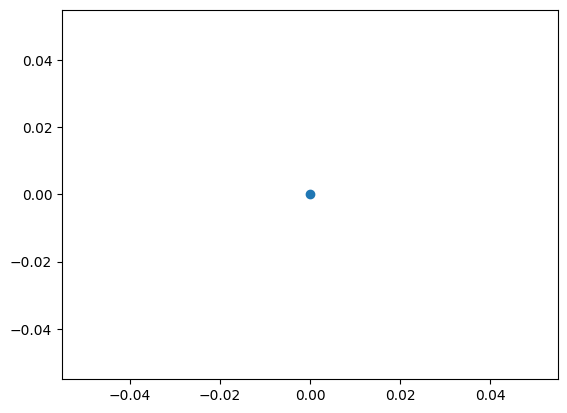

In [132]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP()
se=extract_speaker_embedding(r"C:\Users\AubreeWang\Downloads\DS_10283_3443\VCTK-Corpus-0.92\wav48_silence_trimmed\p261\p261_091_mic2.wav")
embedding = umap_model.fit_transform(se)
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()